In [2]:
from IPython.display import display
from IPython.display import Latex
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import pickle
import os

FSIZE = "full" #"tiny", "small" or "full"

fdir = os.path.join('pickles', 'temporal_analysis')
os.makedirs(fdir, exist_ok = True)



with open(os.path.join(fdir, f'decomposition-{FSIZE}-hourly.p'), 'rb') as f:
    decomp_hourly = pickle.load(f)

with open(os.path.join(fdir, f'decomposition-{FSIZE}-daily.p'), 'rb') as f:
    decomp_daily = pickle.load(f)

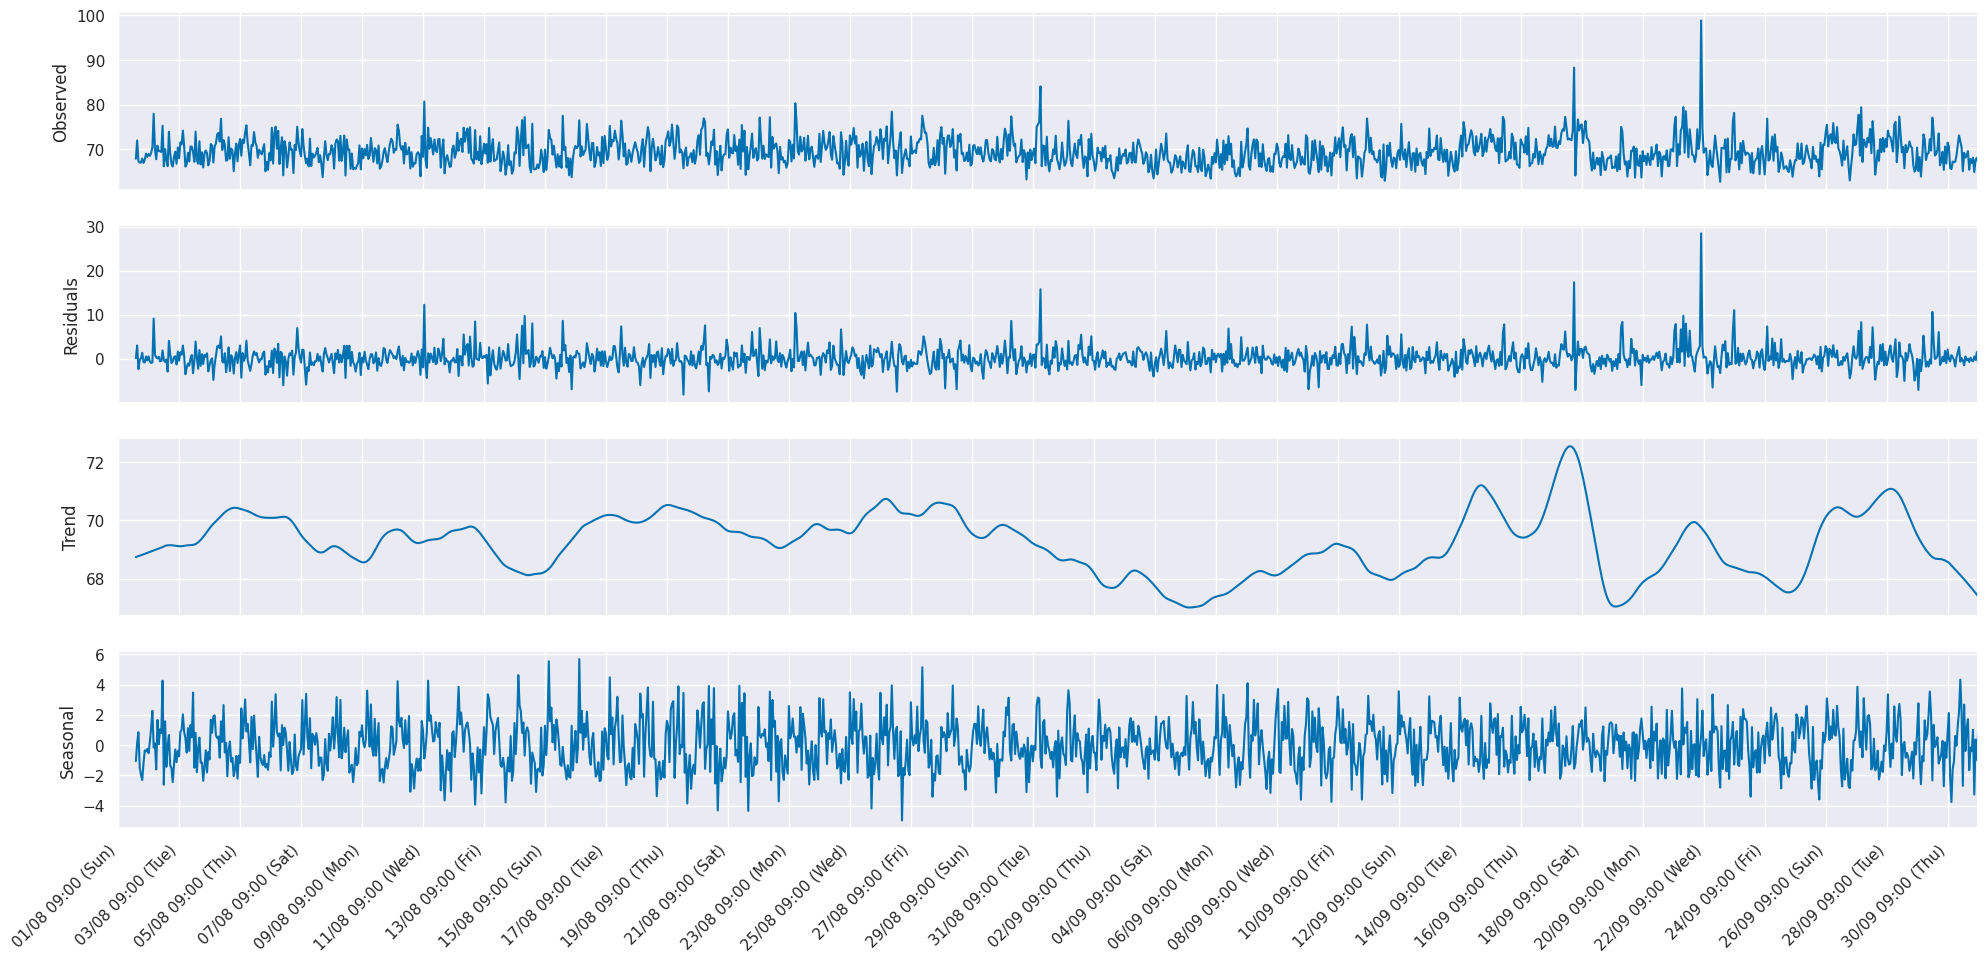

In [3]:
display(decomp_hourly[0]['result']['decompositon']['fig'])

In [9]:
from notebook_shared import decomposeutils as dcu
from notebook_shared import utils
import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

In [5]:
aws_hourly_decomposes = list(filter(lambda decomp: decomp['provider'] == "AWS", decomp_hourly))

In [6]:
decomp_result = aws_hourly_decomposes[0]
decomp_result['result']['parameters']

{'provider': 'AWS',
 'region': 'ap-northeast-1',
 'dt_rounding': 'H',
 'start': None,
 'end': None,
 'adflag': 24,
 'test_regression': 'ct',
 'dtfmt': '%d/%m %H:%M (%a)',
 'xtickstepsize': 2,
 'xticksrotation': 45,
 'plotstart': None}

In [7]:
aws_hourly_decomposes[0]['timezone']

'Asia/Tokyo'

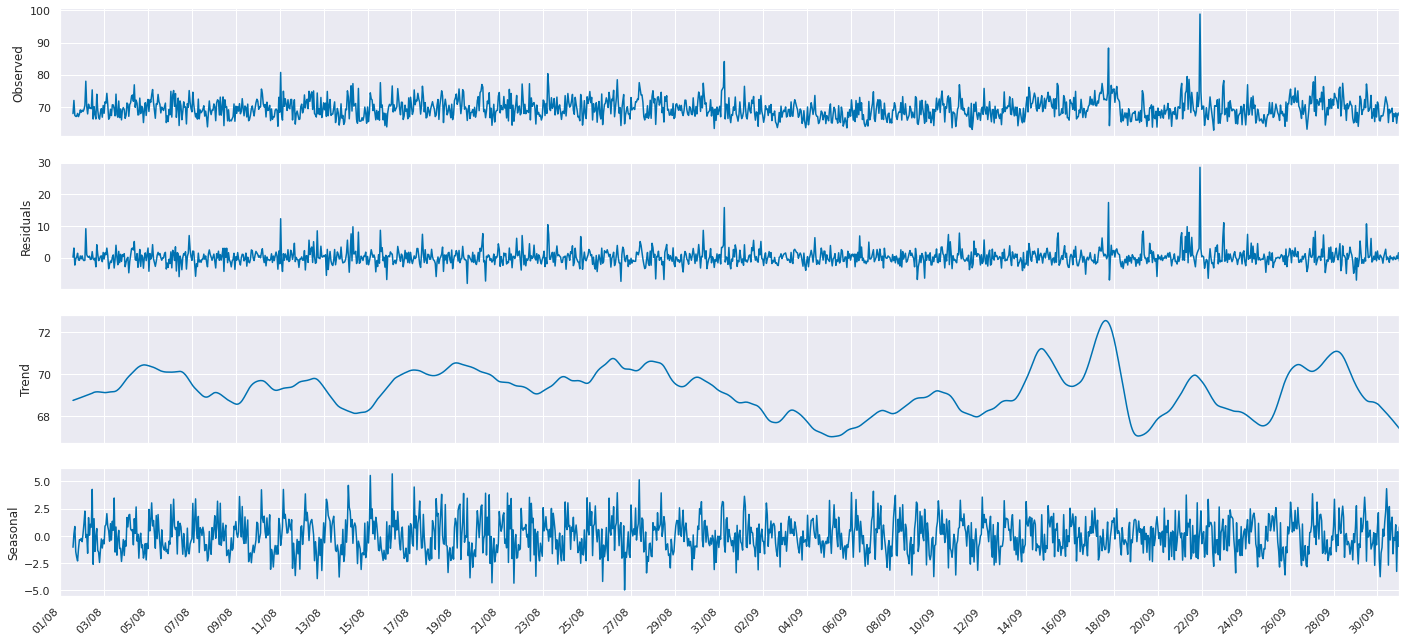

In [10]:
timezone = decomp_result['timezone']
# timezone = decomp_result['parameters']['timezone']
fig = dcu.plot_decompose(decomp_result['result']['decompositon']['data'], timezone)

In [11]:
len(aws_hourly_decomposes)

10

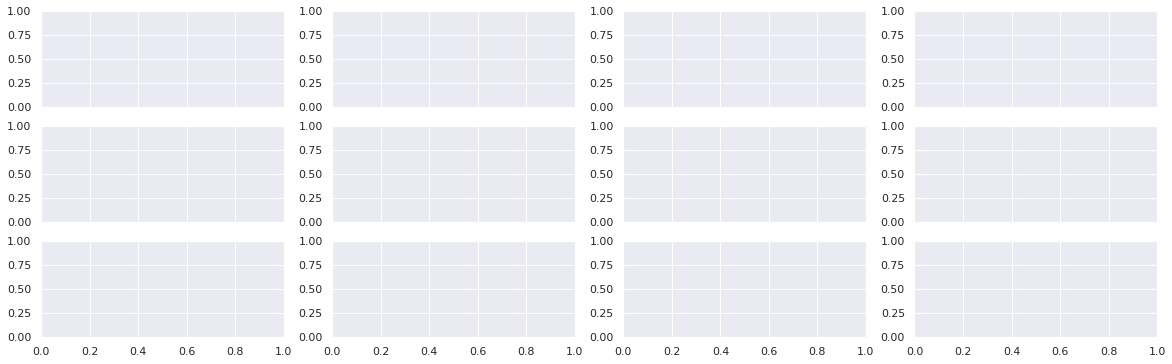

In [14]:
fig, ax = plt.subplots(figsize=(20,6), sharex=True, nrows=3, ncols=4)
for decomp_result in aws_hourly_decomposes:
    timezone = decomp_result['timezone']
    fig = dcu.plot_decompose(decomp_result['result']['decompositon']['data'], timezone)

In [ ]:
def output_casetable(casetab):
    output = ""

    # output += r'\begin{table}[]\begin{tabular}{lll} &  &  \\ &  &  \\ &  & \end{tabular}\end{table}'
    output += r'\begin{table}[h]\begin{tabular}{llllll}  '+ "\n"
    for provider, regions in casetab.items():
        grp = provider
        output += f' Provider & Region & Case 1 & Case 2 & Case 3 & Case 4 \\\\' + "\n"
        for region, case in regions.items():

            case_1 = ""
            if case == "case_1":
                case_1 = "X"
            case_2 = ""
            if case == "case_2":
                case_2 = "X"
            case_3 = ""
            if case == "case_3":
                case_3 = "X"
            case_4 = ""
            if case == "case_4":
                case_4 = "X"

            output += f' {grp} & {region} & {case_1} & {case_2} & {case_3} & {case_4} \\\\' + "\n"
            grp = ""

    output += r'\end{tabular}\end{table}'
    return output

In [ ]:
def create_casetab(data):
    casetab = {}
    for result in data:
        provider = result['provider']
        region = result['region']

        if provider not in casetab.keys():
            casetab[provider] = {}

        casetab[provider][region] = result['result']['stats_test']['case']
    return casetab  

In [ ]:
casetab = create_casetab(data['hourly'])
output = output_casetable(casetab)
Latex(output)

In [ ]:
casetab = create_casetab(data['daily'])
output = output_casetable(casetab)
Latex(output)

In [ ]:
from IPython.display import HTML, display


def print_dict_as_html_table(some_dict):
    
        # create a list that will hold the html content  
        # initialise with the <table> tag
        html_list = ["<table>"]
        
        #iterate through the dictionary, appending row and element tags to the list
        for key in some_dict.keys():
            html_list.append("<tr>")
            html_list.append("<td>{0}</td>".format(key))
            html_list.append("<td>{0}</td>".format(some_dict[key]))
            html_list.append("</tr>")
            
        # add the final </table> tag to the list
        html_list.append("</table>")
        
        # create a string from the list
        html_string = ' '.join([str(elem) for elem in html_list])

        #display the html 
        display(HTML(html_string))


In [ ]:
print_dict_as_html_table(casetab)

# display(casetab)